In [1]:
# Setup and Imports
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from IPython.display import Image, display

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Ensure project_root is defined for subsequent cells
print(f'Project Root: {project_root}')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Common imports
from src.envs.synthetic_env import BouncingBallEnv
from src.envs.atari_env import AtariPixelEnv
from src.models.vae import VAE
from src.models.transition import TransitionModel
from src.models.agent import ActiveInferenceAgent
from src.trainer import ActiveInferenceTrainer

Project Root: /Users/yezune/ws/from_pixels_to_planning
Using device: cpu


objc[54244]: Class CaptureDelegate is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e5d8) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_videoio.4.12.0.dylib (0x12cc14618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[54244]: Class CVWindow is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e628) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c514a70). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[54244]: Class CVView is implemented in both /Users/yezune/ws/from_pixels_to_planning/.venv/lib/python3.14/site-packages/cv2/cv2.abi3.so (0x11826e650) and /opt/homebrew/Cellar/opencv/4.12.0_15/lib/libopencv_highgui.4.12.0.dylib (0x12c514a98). This may cause spu

# Experiment 3: Bouncing Ball

## 1. Bouncing Ball Experiment (Phase 4)

We train a Flat Active Inference Agent on the Bouncing Ball environment and visualize the VAE reconstruction.

Training VAE...


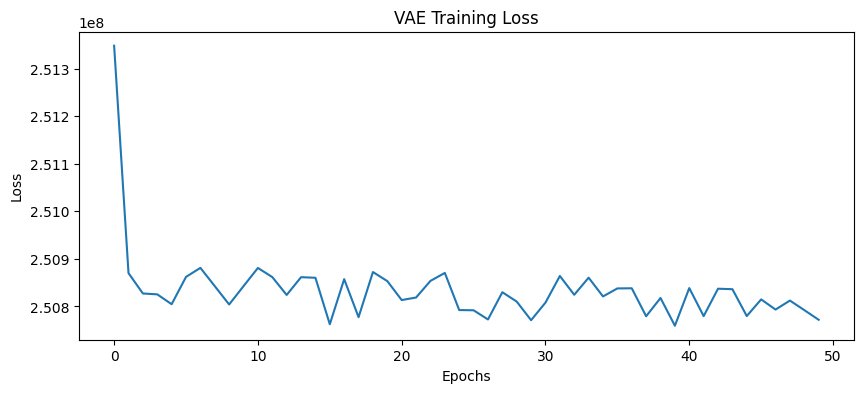

In [2]:
# Initialize Environment and Agent
env = BouncingBallEnv(size=32)
obs_shape = (3, 32, 32)
action_dim = env.action_space.n

vae = VAE(input_shape=obs_shape, latent_dim=16).to(device)
trans = TransitionModel(latent_dim=16, action_dim=action_dim, hidden_dim=32).to(device)
agent = ActiveInferenceAgent(vae, trans, action_dim, device=device)

trainer = ActiveInferenceTrainer(
    env=env,
    agent=agent,
    buffer_size=1000,
    batch_size=16,
    lr=1e-3,
    device=device
)

# Collect Data and Train (Short Run)
print("Collecting data...")
trainer.collect_data(num_steps=200)

print("Training VAE...")
vae_losses = []
for _ in range(50):
    loss = trainer.train_vae(epochs=1)
    vae_losses.append(loss)

plt.figure(figsize=(10, 4))
plt.plot(vae_losses)
plt.title("VAE Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Visualizing Sequence...


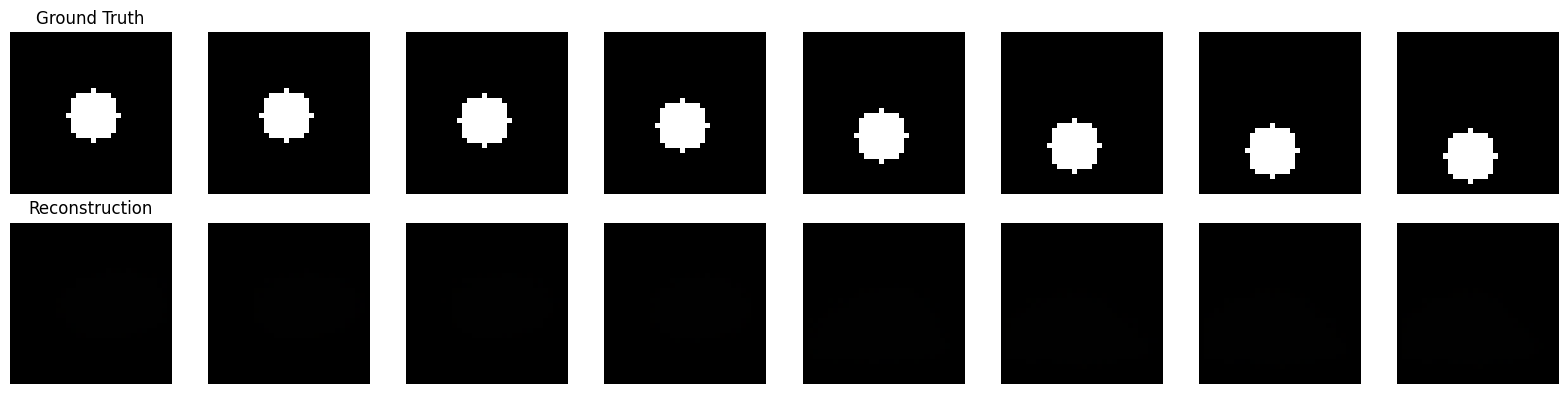

In [3]:
# 1. Sequence Visualization (Trajectory Tracking)
# 공의 움직임(Trajectory)을 따라가며 원본과 재구성 이미지를 비교합니다.
def visualize_sequence(agent, env, num_steps=10):
    obs, _ = env.reset()
    
    originals = []
    reconstructions = []
    
    for _ in range(num_steps):
        # Process Observation
        if not isinstance(obs, torch.Tensor):
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
        else:
            obs_tensor = obs.to(device)
            
        if obs_tensor.shape[-1] == 3:
            obs_tensor = obs_tensor.permute(2, 0, 1)
        
        obs_tensor = obs_tensor.unsqueeze(0)
        
        # VAE Reconstruction
        with torch.no_grad():
            recon, _, _ = agent.vae(obs_tensor)
            
        # Store images
        orig_img = obs_tensor.squeeze().permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)
        
        originals.append(orig_img)
        reconstructions.append(recon_img)
        
        # Step Env (Random Action for now)
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)

    # Plot
    fig, axes = plt.subplots(2, num_steps, figsize=(2 * num_steps, 4))
    for i in range(num_steps):
        axes[0, i].imshow(originals[i])
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_title("Ground Truth")
        
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_title("Reconstruction")
    
    plt.tight_layout()
    plt.show()

print("Visualizing Sequence...")
visualize_sequence(agent, env, num_steps=8)

Generating Animation...
Animation saved to bouncing_ball.gif
Animation saved to bouncing_ball.gif


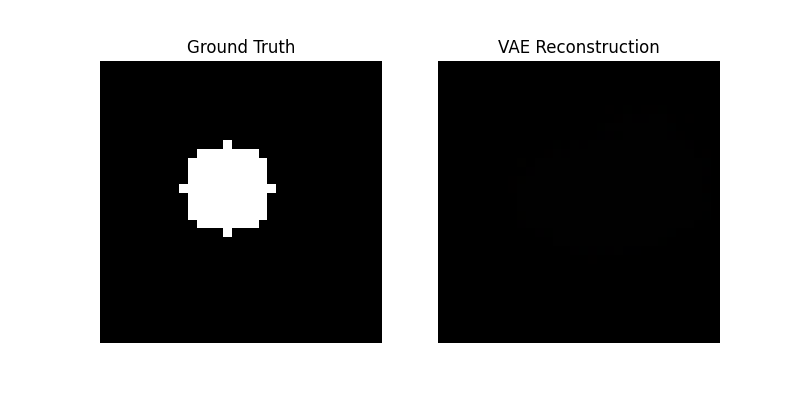

In [4]:
# 2. Generate GIF Animation (Real-time Tracking)
# 공이 튀어 다니는 모습을 애니메이션으로 생성하여 모델의 실시간 처리 능력을 확인합니다.
import matplotlib.animation as animation

def create_animation(agent, env, num_frames=50, filename='bouncing_ball.gif'):
    obs, _ = env.reset()
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].set_title("Ground Truth")
    axes[1].set_title("VAE Reconstruction")
    
    img1 = axes[0].imshow(np.zeros((32, 32, 3)), animated=True)
    img2 = axes[1].imshow(np.zeros((32, 32, 3)), animated=True)
    axes[0].axis('off')
    axes[1].axis('off')
    
    def update(frame):
        nonlocal obs
        # Process Observation
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device)
        if obs_tensor.shape[-1] == 3:
            obs_tensor = obs_tensor.permute(2, 0, 1)
        obs_tensor = obs_tensor.unsqueeze(0)
        
        with torch.no_grad():
            recon, _, _ = agent.vae(obs_tensor)
            
        orig_img = obs.astype(np.uint8)
        recon_img = recon.squeeze().permute(1, 2, 0).cpu().numpy()
        recon_img = np.clip(recon_img, 0, 255).astype(np.uint8)
        
        img1.set_array(orig_img)
        img2.set_array(recon_img)
        
        # Step
        action = env.action_space.sample()
        obs, _, _, _, _ = env.step(action)
        return img1, img2

    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True)
    ani.save(filename, writer='pillow', fps=15)
    plt.close()
    print(f"Animation saved to {filename}")
    return filename

print("Generating Animation...")
gif_path = create_animation(agent, env, num_frames=60)
display(Image(filename=gif_path))